# Generating Bounding Boxes from Audio Annotations

This notebook aims to generate a new column in a CSV file containing the normalized coordinates of the bounding boxes based on audio annotations. Audio annotations are represented in a pandas DataFrame containing information about the time, frequency, and associated species for each annotation. The normalized coordinates of the bounding boxes will be calculated in relation to the dimensions of the corresponding spectrogram image.

**Steps:**

1. Load the CSV file containing the audio annotations.
2. Define the function to calculate the normalized coordinates of the bounding boxes.
3. Iterate over the rows of the annotations DataFrame to calculate the coordinates and add them to the DataFrame.
4. Save the modified DataFrame to a new CSV file.

**Requirements:**

- The CSV file of annotations must contain the following columns: 'start_time', 'end_time', 'low_frequency', 'high_frequency', 'specie', 'path' (path to the corresponding image).


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [29]:
ROOT_PATH = "../../../desarrollo/"

# Path to the CSV file of audio annotations
csv_file = ROOT_PATH + "Data/Annotations/audio_annotations.csv"

In [30]:
# Load the CSV file into a pandas DataFrame
annotations_df = pd.read_csv(csv_file)

# Display the first few rows of the DataFrame to verify the correct loading of data
annotations_df.head()

,path,annotator,recorder,date,time,audio_duration,start_time,end_time,low_frequency,high_frequency,specie
0,AM1/2023_05_10/AM1_20230510_060000.WAV,Edu,AM1,2023/05/10,06:00:00,00:01:00,0.000000,0.565714,1857.890806,6823.249512,cyanopica cooki
1,AM1/2023_05_10/AM1_20230510_060000.WAV,Edu,AM1,2023/05/10,06:00:00,00:01:00,5.854286,6.960000,3610.597656,6273.062012,abiotic noise
2,AM1/2023_05_10/AM1_20230510_060000.WAV,Edu,AM1,2023/05/10,06:00:00,00:01:00,5.854286,6.934286,0.000000,1785.524170,abiotic noise
3,AM1/2023_05_10/AM1_20230510_060000.WAV,Edu,AM1,2023/05/10,06:00:00,00:01:00,5.914286,6.925714,1881.718994,3449.984619,cyanopica cooki
4,AM1/2023_05_10/AM1_20230510_060000.WAV,Edu,AM1,2023/05/10,06:00:00,00:01:00,6.960000,11.297143,18.972063,5970.894531,abiotic noise


In [31]:
IMAGE_ROOT_PATH = image_path = ROOT_PATH + "Data/Dataset/images/"
image_path = ROOT_PATH + "Data/Dataset/images/" + annotations_df["path"][0].replace(".WAV", ".PNG")
img = plt.imread(image_path)
WIDTH = img.shape[1]
HEIGHT = img.shape[0]

MAX_FREQUENCY = 16000

In [32]:
print("Image dimensions: ", WIDTH, "x", HEIGHT)

Image dimensions:  930 x 462


In [33]:
# Function to convert HH:MM:SS format to seconds
def hms_to_seconds(hms):
    if isinstance(hms, str):
        time_parts = hms.split(':')
        if len(time_parts) == 3:
            hours, minutes, seconds = map(int, time_parts)
            total_seconds = hours * 3600 + minutes * 60 + seconds
            return total_seconds
    elif isinstance(hms, float):
        return float(hms)
    return None

In [34]:
MAX_FREQUENCY = 32000

In [35]:
# Definir la función de conversión de frecuencia a mel
def hz_to_mel(frequencies):
    return 2595 * np.log10(1 + frequencies / 700)

In [36]:
# Function to calculate the normalized bounding box coordinates
def calculate_bbox_no_mel(row):
    audio_duration = row['audio_duration']
    audio_duration = hms_to_seconds(audio_duration)

    # Get the coordinates of the annotations
    start_time = row['start_time']
    end_time = row['end_time']
    low_frequency = row['low_frequency']
    high_frequency = row['high_frequency']

    if start_time is not None and end_time is not None:
        start = int(start_time / audio_duration * WIDTH)
        end = int(end_time / audio_duration * WIDTH)

    # Set maximum frequency to 16000 Hz if high_frequency is -1 (unknown)
    if high_frequency == -1:
        high_frequency = MAX_FREQUENCY

    if low_frequency <= 1:
        bottom = 1
    else:
        bottom = float(np.log(low_frequency) / np.log(MAX_FREQUENCY) * img.shape[0])

    if high_frequency == 160000:
        top = 160000
    else:
        top = float(np.log(high_frequency) / np.log(MAX_FREQUENCY) * img.shape[0])

    # Invert the y-coordinates
    bottom, top = img.shape[0] - top, img.shape[0] - bottom

    # print(start, end, bottom, top)
    
    # Calculate the normalized coordinates of the bounding box center and size
    x_center = (start + end) / 2
    y_center = (top + bottom) / 2
    width = (end - start)
    height = (top - bottom)

    # Normalize x_center and y_center
    x_center /= WIDTH
    y_center /= HEIGHT
    width /= WIDTH
    height /= HEIGHT

    assert 0 <= x_center <= 1, row
    assert 0 <= y_center <= 1, row
    # assert else print
    #assert 0 <= width <= 1, row
    #assert 0 <= height <= 1, row
    
    # Return the coordinates in list format
    return [x_center, y_center, width, height]

In [37]:
# Function to calculate the normalized bounding box coordinates
def calculate_bbox(row):
    audio_duration = row['audio_duration']
    audio_duration = hms_to_seconds(audio_duration)

    # Get the coordinates of the annotations
    start_time = row['start_time']
    end_time = row['end_time']
    low_frequency = row['low_frequency']
    high_frequency = row['high_frequency']

    if start_time is not None and end_time is not None:
        start = int(start_time / audio_duration * WIDTH)
        end = int(end_time / audio_duration * WIDTH)

    # Convert frequencies to mel scale
    low_mel = hz_to_mel(low_frequency)
    high_mel = hz_to_mel(high_frequency)

    # Map mel frequencies to y-axis coordinates
    bottom = float(low_mel / hz_to_mel(MAX_FREQUENCY) * img.shape[0])
    top = float(high_mel / hz_to_mel(MAX_FREQUENCY) * img.shape[0])

    # Invert the y-coordinates
    bottom, top = img.shape[0] - top, img.shape[0] - bottom

    # Calculate the normalized coordinates of the bounding box center and size
    x_center = (start + end) / 2
    y_center = (top + bottom) / 2
    width = (end - start)
    height = (top - bottom)

    # Normalize x_center and y_center
    x_center /= WIDTH
    y_center /= HEIGHT
    width /= WIDTH
    height /= HEIGHT

    assert 0 <= x_center <= 1, row
    assert 0 <= y_center <= 1, row
    assert 0 <= width <= 1, row
    assert 0 <= height <= 1, row

    # Return the coordinates in list format
    return [x_center, y_center, width, height]

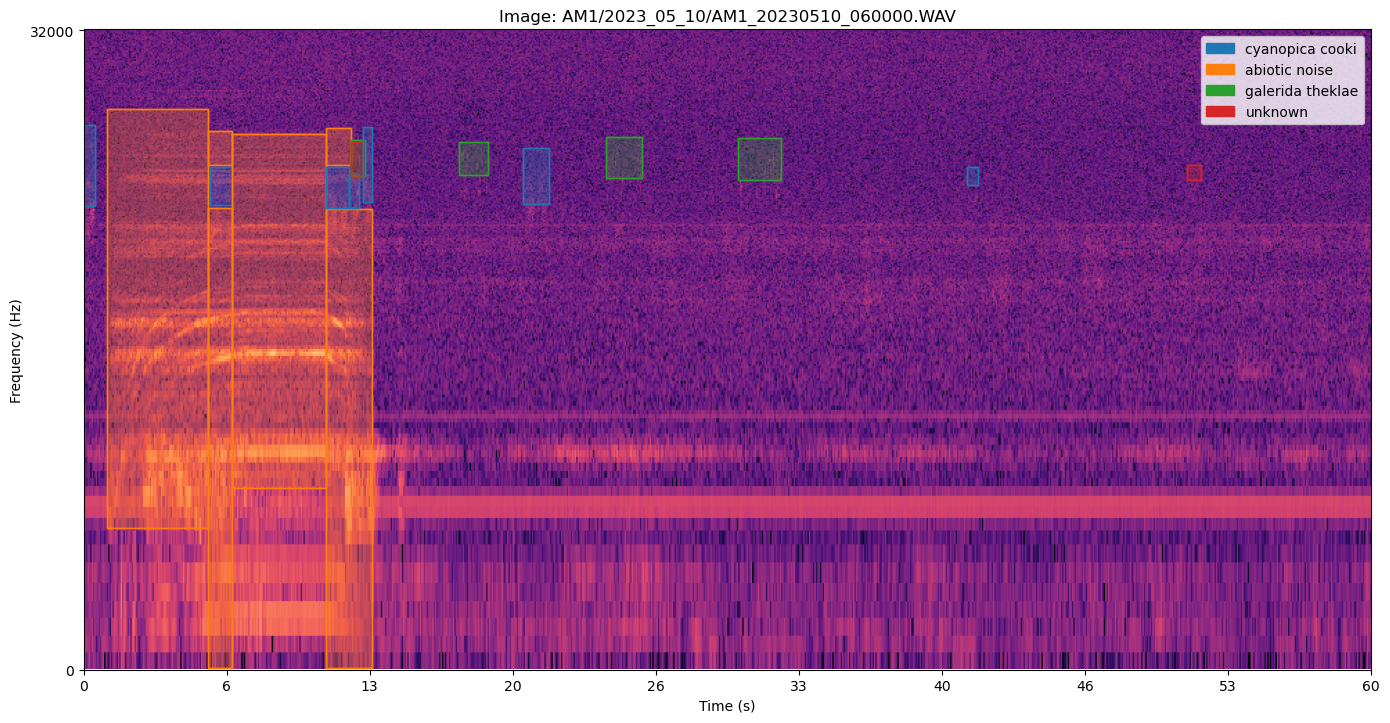

In [38]:
def plot_image_with_yolo_bboxes(audio_path, df):
    # Filter DataFrame for rows matching the audio path
    matching_rows = df[df['path'] == audio_path]

    # Load the audio spectrogram image (assuming it's saved as an image)
    image_path = IMAGE_ROOT_PATH + audio_path.replace(".WAV", ".PNG")

    # Load the audio image
    img = plt.imread(image_path)
    
    # Create a figure and axis for the image
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Display the audio image
    ax.imshow(img)
    ax.set_title(f'Image: {audio_path}')

    # Create a color map
    cmap = plt.get_cmap('tab10')
    species = matching_rows['specie'].unique()
    color_dict = {specie: cmap(i) for i, specie in enumerate(species)}

    # Add bounding boxes
    for index, row in matching_rows.iterrows():
        # Create a Rectangle patch
        bbox = calculate_bbox_no_mel(row)

        # Unnormalize the bounding box coordinates
        x_center, y_center, width, height = bbox
        x_center *= WIDTH
        y_center *= HEIGHT
        width *= WIDTH
        height *= HEIGHT

        # Convert the bounding box coordinates to the format (x_min, y_min, width, height)
        x_min = x_center - (width / 2)
        y_min = y_center - (height / 2)

        # Create a Rectangle patch
        # Create a Rectangle patch with color based on species
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor=color_dict[row['specie']], facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

        ax.fill_betweenx([y_min, y_min + height], x_min, x_min + width, color=color_dict[row['specie']], alpha=0.3)

        # Add the patch to the Axes
        ax.add_patch(rect)

    # Create legend
    patch_list = [patches.Patch(color=color_dict[specie], label=specie) for specie in species]
    plt.legend(handles=patch_list)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')

    # Customize y-axis ticks and labels for frequency
    freq_ticks = [0, MAX_FREQUENCY]
    freq_labels = [str(tick) for tick in freq_ticks]
    ax.set_yticks([int(tick / MAX_FREQUENCY * img.shape[0]) for tick in freq_ticks])
    ax.set_yticklabels(np.flipud(freq_labels))  # Invert the frequency labels

    # Customize x-axis
    ax.set_xlim([0, 60])
    ax.set_xticks(np.linspace(0, img.shape[1], num=10))
    ax.set_xticklabels([str(int(tick / img.shape[1] * 60)) for tick in ax.get_xticks()])

    # Show the plot
    plt.tight_layout()
    plt.show()

# Plot the image with bounding boxes for the first audio file
audio_path = annotations_df['path'][15]
plot_image_with_yolo_bboxes(audio_path, annotations_df)

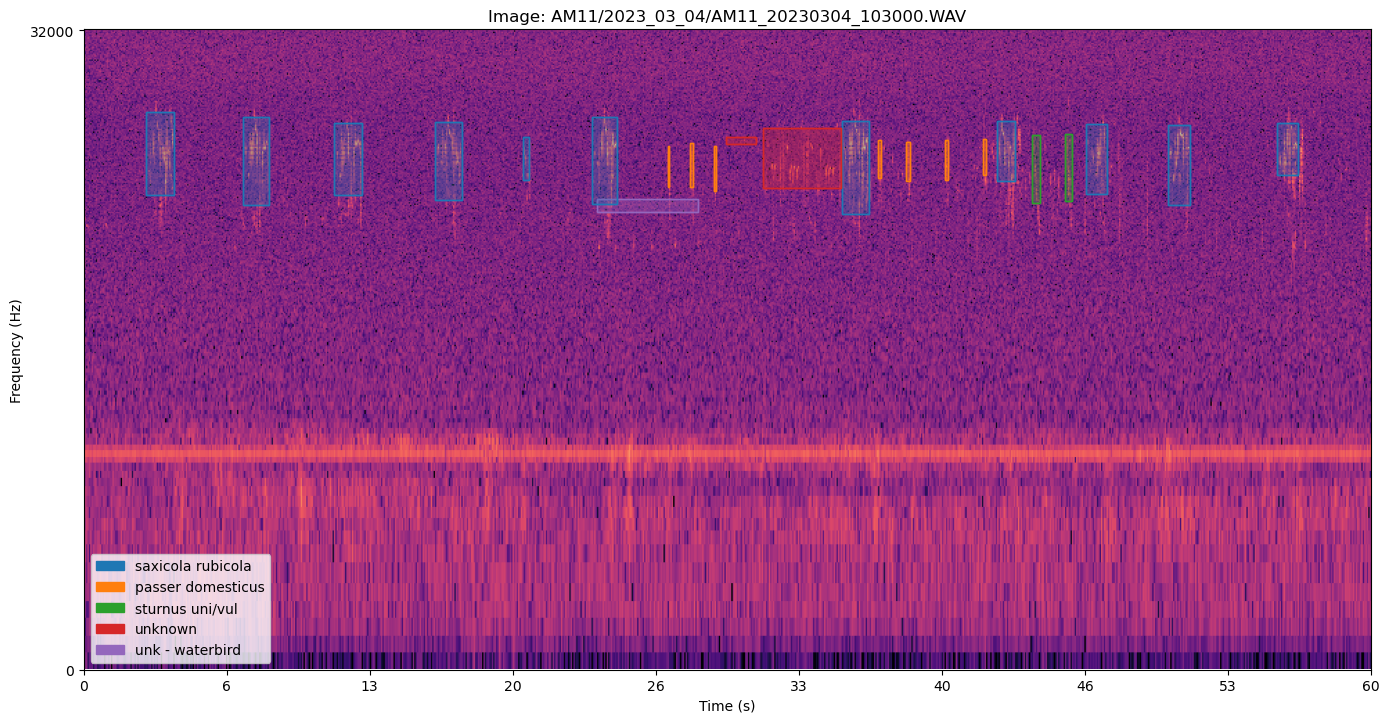

In [39]:
audio_name = "AM11_20230304_103000.WAV"

# Load image from audio
image_name = audio_name.replace(".WAV", "")

# Define the root path for the Images directory
image_root_directory = ROOT_PATH + "Data/Dataset/images/"

# Filter rows that match the given audio name
filtered_df = annotations_df[annotations_df['path'].str.contains(audio_name)]

# Delete indexes from the filtered dataframe
filtered_df.reset_index(drop=True, inplace=True)

image_path = ROOT_PATH + "Data/Dataset/images/" + filtered_df["path"][0].replace(".WAV", ".PNG")

plot_image_with_yolo_bboxes(filtered_df["path"][0], annotations_df)

In [40]:
# Calculate the normalized coordinates of the bounding boxes and add them as a new column
annotations_df['bbox'] = annotations_df.apply(lambda row: calculate_bbox_no_mel(row), axis=1)

# Display the first few rows of the modified DataFrame to verify the results
annotations_df.head()

AssertionError: path              AM16/2023_05_30/AM16_20230530_101000.WAV
annotator                                           Giulia
recorder                                              AM16
date                                            2023/05/30
time                                              10:10:00
audio_duration                                    00:01:00
start_time                                       40.768852
end_time                                         99.535361
low_frequency                                  4673.780273
high_frequency                                 7308.379395
specie                                  cisticola juncidis
Name: 1699, dtype: object

In [ ]:
# Path to the new CSV file with bounding box coordinates
output_csv_file = csv_file

# Save the modified DataFrame to a new CSV file
annotations_df.to_csv(output_csv_file, index=False)

print("CSV file with bounding boxes created successfully.")

CSV file with bounding boxes created successfully.
